In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib
import scipy
from efficientnet_pytorch import EfficientNet

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)

# 学習データの作成

In [3]:
def get_heatmap(h, w, h_center, w_center, sigma=2):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

In [4]:
def line2P(l):
    P_elem = l.split()[1:]
    P = np.array(P_elem, dtype=np.float).reshape(3,-1)
    return P

def readCalib(calib_name, calib_path):
    calib_name = calib_path + calib_name + ".txt"
    with open(calib_name) as f:
        P0 = line2P(f.readline())
        P1 = line2P(f.readline())
        P2 = line2P(f.readline())
        P3 = line2P(f.readline())
        R0_rect = line2P(f.readline())
        Tr_velo_to_cam = line2P(f.readline())
        Tr_imu_to_velo = line2P(f.readline())
    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

def projectToImage(pts3D, P):
    P = np.array(P)
    
    ones = np.ones([1,pts3D.shape[1]])
    pts3D = np.append(pts3D, ones, axis=0)
    pts2D = np.dot(P, pts3D)
    pts2D[0] /= pts2D[2]
    pts2D[1] /= pts2D[2]
    pts2D = np.delete(pts2D, obj=2, axis=0)
    return pts2D

def selectVisibleSurface(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # right
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # left
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    surface_coord3D = np.zeros([3,4])
    visible_flag = np.zeros(4)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        surface_coord3D[:,i] = c_plane
        if np.dot(c_to_O, normal)>0:
            visible_flag[i] = 1
    return visible_flag==1, surface_coord3D

def selectVisiblePoint(corner3D):
    # 直方体の8点から、隠れた点を除いて出力する
    face_mask = np.array([[1,1,0,0,1,1,0,0], # front
                          [0,1,1,0,0,1,1,0], # right
                          [0,0,1,1,0,0,1,1], # back
                          [1,0,0,1,1,0,0,1]  # left
                         ])

    # 直方体の中心位置を計算
    c_rectangular = np.sum(corner3D, axis=1)/8

    # 各面の法線と面からカメラへの直線がなす角度が90度以下であればその面は見える
    visible_mask = np.zeros(8)
    for i in range(4):
        p_in_plane = corner3D * face_mask[i] # 平面の4つの頂点
        c_plane = np.sum(p_in_plane, axis=1)/4 # 平面の中心
        normal = c_plane - c_rectangular# 平面の法線ベクトル
        c_to_O = -c_plane # 平面の中心からカメラ位置へのベクトル
        if np.dot(c_to_O, normal)>0:
            visible_mask += face_mask[i]
    return visible_mask!=0

def compute3Dbb(obj, P):
    # 直方体の各頂点のxyz座標を計算
    face_idx = np.array([[0,1,5,4], # front face
                         [1,2,6,5], # right face
                         [2,3,7,6], # back face
                         [3,0,4,7]]) # left face
    ry = obj["rotation_y"]
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]],
                 dtype=np.float)
    l = obj["length"]
    w = obj["width"]
    h = obj["height"]
    corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                        [0,0,0,0,-h,-h,-h,-h],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                       dtype=np.float).reshape(3,-1)
    corner3D = np.dot(R,corners)
    xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
    corner3D += xyz
    
    # 直方体の各頂点が見えているかどうかを判定
    visible_corner_flag = selectVisiblePoint(corner3D) # 見える頂点を判定
    corner_coord2D = projectToImage(corner3D, P) # 画像座標に変換
    
    # 直方体の面の座標、面が見えているかどうかを判定
    visible_surface_flag, surface_coord3D = selectVisibleSurface(corner3D)
    surface_coord2D = projectToImage(surface_coord3D, P)
    
    if xyz[2]<0.1:
        return []
    else:
        return visible_corner_flag, corner_coord2D, visible_surface_flag, surface_coord2D

def getP2(img_name):
    calib_path = "../data/training/calib/"
    _, _, P2, _, _, _, _ = readCalib(img_name, calib_path)
    return P2

In [18]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img, training=False):
    #scale, aspect racioを変更
    scale = rand()*.3+1.5
    aspect_ratio = rand()*0.15
    fx = scale/RESIZE_SCALE*(1+aspect_ratio)
    fy = scale/RESIZE_SCALE
    resized_img = cv2.resize(img, dsize=None, fx=fx, fy=fy)
    assert np.max(img)<=1, "image data is not scaled within 0~1"
    
    #img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    if training:
        img_shape = resized_img.shape[0], resized_img.shape[1]
        off_x = randint(0, img_shape[1]-IMG_WIDTH)
        off_y = randint(0, img_shape[0]-IMG_HEIGHT)
    else:
        off_x = np.round((IMG_WIDTH-img_shape[1])/2).astype('int')
        off_y = np.round((IMG_HEIGHT-img_shape[0])/2).astype('int')
    
    #img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    #resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    #img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    
    img_dummy = resized_img[off_y:off_y+IMG_HEIGHT,off_x:off_x+IMG_WIDTH]
    return img_dummy.astype('float32'), (off_x, off_y), (fx, fy)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0), scale=(1,1)):
    
    ## mask data
    # idx 0 : vehicle
    # idx 1 : front and rear side
    # idx 2 : right and left side
    # idx 3 : 3D corner
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 4], dtype='float32')
    ## size of the vehicle : width, height
    regr_size = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    ## offset for 3D detection
    # idx 0,10 : offset from vehicle center to front or rear surface | x, y
    # idx 1,11 : offset from vehicle center to right or left surface | x, y
    # idx 2~5,12~15 : offset from surface(front, rear) to each 3D corner
    #                                                               | rb_x, lb_x, lt_x, rt_x, ..., rt_y
    # idx 6~9,16~19 : offset from surface(right, or left) to each 3D corner
    #                                                               | rb_x, lb_x, lt_x, rt_x, ..., rt_y
    regr_3D = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 20], dtype='float32')
    
    # 車両が重なってmaskを0にしたところを判定。0で学習しないように。
    mask_overlap = np.zeros_like(mask)
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]

    P2 = getP2(img_name)
    
    target_type = ['Car', 'Van', 'Truck']

    # annotationを遠い順に並び替え
    annos = []
    for _, anno in annotations.iterrows():
        annos.append(anno)
    annos_sorted = sorted(annos, key=lambda x:x['z'], reverse=True)
    
    for anno in annos_sorted:
        if anno["type"] in target_type:
            ## center pointの学習データを作成 
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2
            y = (anno["top"]+anno["bottom"])/2
            width = (anno["right"]-anno["left"])
            height = (anno["bottom"]-anno["top"])
            
            x = (x*scale[0]-offset[0])/MODEL_SCALE
            y = (y*scale[1]-offset[1])/MODEL_SCALE
            
            width = width*scale[0]/MODEL_SCALE
            height = height*scale[1]/MODEL_SCALE

            ## corner, surfaceの座標を計算
            try: # 前後距離が小さいものは無視
                vsbl_cnr_flg, cnr, vsbl_sfc_flg, sfc = compute3Dbb(anno, P2)
            except:
                continue
            cnr[0] = (cnr[0]*scale[0]-offset[0])/MODEL_SCALE
            cnr[1] = (cnr[1]*scale[1]-offset[1])/MODEL_SCALE
            sfc[0] = (sfc[0]*scale[0]-offset[0])/MODEL_SCALE
            sfc[1] = (sfc[1]*scale[1]-offset[1])/MODEL_SCALE
            
            ## コーナーの4点が全て画像外だったら何もしない
            if np.max(cnr[0])<0 or IMG_WIDTH//MODEL_SCALE<np.min(cnr[0]) or\
               np.max(cnr[1])<0 or IMG_HEIGHT//MODEL_SCALE<np.min(cnr[1]):
                continue
            
            w = max(width,1)
            h = max(height,1)
            left = np.round(max(min(x-w/2,np.min(cnr[0])),0)).astype('int')
            top = np.round(max(min(y-h/2,np.min(cnr[1])),0)).astype('int')
            right = np.round(min(max(x+w/2,np.max(cnr[0])),IMG_WIDTH // MODEL_SCALE)).astype('int')
            bottom = np.round(min(max(y+h/2,np.max(cnr[1])),IMG_HEIGHT // MODEL_SCALE)).astype('int')
            if x<left or right<x or y<top or bottom<y:
                x = (right+left)/2
                y = (bottom+top)/2
            hm = get_heatmap(right-left, bottom-top, x-left, y-top,
                             sigma=max(min(right-left,bottom-top)/5,3))
            
            # 隠れている車両の正解データを消去(maskのみ)
            pts = cv2.convexHull(np.round(cnr).T.astype(np.int32))
            cv2.fillConvexPoly(mask, points=pts, color=0)

            # x, y, width, heightからmask, regrを作成
            mask[top:bottom, left:right, 0] = hm
            regr_size[top:bottom, left:right, 0] = width
            regr_size[top:bottom, left:right, 1] = height
            
            # regressionデータの初期化
            nums = np.arange(0,right-left,1)
            nums = np.tile(nums,10).reshape(10,right-left).T
            nums = np.tile(nums,(bottom-top,1)).reshape(bottom-top,right-left,10)
            regr_3D[top:bottom, left:right,:10] = nums
            nums = np.arange(0,bottom-top,1)
            nums = np.tile(nums,10).reshape(10,bottom-top).T
            nums = np.tile(nums,right-left).reshape(bottom-top,right-left,10)
            regr_3D[top:bottom, left:right,10:] = nums
            
            # 
            face_idx = np.array([[0,1,5,4], # front face
                                 [1,2,6,5], # right face
                                 [2,3,7,6], # back face
                                 [3,0,4,7]]) # left face
            ## front, rear
            for i in range(0,5,2):
                if i < 4 and vsbl_sfc_flg[i]==1:
                    # front, rear中心へのregressionを設定
                    regr_3D[top:bottom, left:right, 0] -= (sfc[0,i]-left) # xベクトル
                    regr_3D[top:bottom, left:right, 10] -= (sfc[1,i]-top) # yベクトル
                    
                    # front, rear中心から側面の4点へのregressionを設定
                    sfc_cnr = cnr[:,face_idx[i]] # 側面の四角形の座標
                    # regressionのoffsetを計算
                    for j in range(4):
                        regr_3D[top:bottom, left:right,j+2] -= (sfc_cnr[0,j]-left)
                        regr_3D[top:bottom, left:right,j+2+10] -= (sfc_cnr[1,j]-top)
                    break
                elif i==4:
                    # frontもrearも見えていなかったら
                    regr_3D[top:bottom, left:right, 0] = 0 # xベクトル
                    regr_3D[top:bottom, left:right, 10] = 0 # yベクトル
            # right, left
            for i in range(1,6,2):
                if i < 5 and vsbl_sfc_flg[i]==1:
                    regr_3D[top:bottom, left:right, 1] -= (sfc[0,i]-left) # xベクトル
                    regr_3D[top:bottom, left:right, 11] -= (sfc[1,i]-top) # yベクトル
                    
                    # right, left中心から側面の4点へのregressionを設定
                    sfc_cnr = cnr[:,face_idx[i]] # 側面の四角形の座標
                    # regressionのoffsetを計算
                    for j in range(4):
                        regr_3D[top:bottom, left:right,j+6] -= (sfc_cnr[0,j]-left)
                        regr_3D[top:bottom, left:right,j+6+10] -= (sfc_cnr[1,j]-top)
                    break
                elif i==5:
                    # rightもleftも見えていなかったら
                    regr_3D[top:bottom, left:right, 1] = 0 # xベクトル
                    regr_3D[top:bottom, left:right, 11] = 0 # yベクトル

            # cornerのmaskを作成
            cnr = cnr[:,vsbl_cnr_flg]
            cnr = np.round(cnr).astype('int')
            if w > 3:
                for i in range(cnr.shape[1]):
                    if 0 <= cnr[1,i] and cnr[1,i] < mask.shape[0] and\
                       0 <= cnr[0,i] and cnr[0,i] < mask.shape[1]:
                        # 画像外だったら何もしない
                        mask[cnr[1,i],cnr[0,i],3] = 1
            # surfaceのmaskを作成
            sfc = np.round(sfc).astype('int')
            if w > 3:
                for i in range(4):
                    if 0 <= sfc[1,i] and sfc[1,i] < mask.shape[0] and \
                       0 <= sfc[0,i] and sfc[0,i] < mask.shape[1] and \
                       vsbl_sfc_flg[i]==1:
                        # 画像外だったら何もしない
                        if i%2==0: # 前後面のmaskを設定
                            hm = get_heatmap(right-left, bottom-top, sfc[0,i]-left, sfc[1,i]-top, 
                                             sigma=max(min(right-left,bottom-top)/5,2))
                            mask[top:bottom, left:right, 1] = hm
                        else:
                            hm = get_heatmap(right-left, bottom-top, sfc[0,i]-left, sfc[1,i]-top, 
                                             sigma=max(min(right-left,bottom-top)/5,2))
                            mask[top:bottom, left:right, 2] = hm
            mask_overlap = np.maximum(mask_overlap, mask)
    
    mask_not_suppressed = (mask_overlap-mask)<0.1
    return mask, regr_size, regr_3D, mask_not_suppressed

In [19]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

In [20]:
img_name = train_list[8]
img_name_list = get_img_path([img_name])
img = plt.imread(img_name_list[0])
img, offset, scale = preprocess_image(img,True)
mask, regr_size, regr_3D, mask_not_suppressed = get_mask_and_regr(img_name, annotations_list, offset, scale)

### check each loss

In [33]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset, scale = preprocess_image(img, self.training)
        
        if self.training:
            mask, regr_size, regr_3D, mask_not_suppressed = get_mask_and_regr(img_name, self.anno, offset, scale)
            # Augmentation
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr_size, regr_3D, mask_not_suppressed =\
                    img[:,::-1], mask[:,::-1], regr_size[:,::-1], regr_3D[:,::-1], mask_not_suppressed[:,::-1]
                regr_3D[:,:,0:10] *= -1
                regr_3D = regr_3D[:,:,[0,1,3,2,5,4,7,6,9,8,10,11,13,12,15,14,17,16,19,18]] # corner regressionを左下から時計回りに修正
            fliptb = rand()>.5
            if fliptb:
                img, mask, regr_size, regr_3D, mask_not_suppressed =\
                    img[::-1], mask[::-1], regr_size[::-1], regr_3D[::-1], mask_not_suppressed[::-1]
                regr_3D[:,:,10:] *= -1
                regr_3D = regr_3D[:,:,[0,1,5,4,3,2,9,8,7,6,10,11,15,14,13,12,19,18,17,16]] # corner regressionを左下から時計回りに修正
        
            # 配列の向き？を入れ替える
            mask = np.rollaxis(mask, 2, 0)
            regr_size = np.rollaxis(regr_size, 2, 0)
            regr_3D = np.rollaxis(regr_3D, 2, 0)
            mask_not_suppressed = np.rollaxis(mask_not_suppressed, 2, 0)
        img = np.rollaxis(img, 2, 0)
        
        if self.training:
            return [img.copy(), mask.copy(), regr_size.copy(), regr_3D.copy(), mask_not_suppressed.copy()]
        else:
            return img

In [34]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)

In [35]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1)

In [36]:
lambda_size = 0.01
lambda_3D = 0.1

def criterion(prediction, mask, regr_size, regr_3D, mask_not_suppressed):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0:4])
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    # 車両のoverlapによりmaskが抑制されたところは、車両ありと推測しても罰則を与えない
    mask_loss = mask_loss * mask_not_suppressed
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression size loss
    pred_regr = prediction[:, 4:6]
    size_loss = (torch.abs(pred_regr - regr_size).sum(1) * mask[:,0]).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    size_loss = size_loss.mean(0)
    
    # Regression 3D loss
    pred_regr = prediction[:,[6,7,16,17]]
    regr = regr_3D[:,[0,1,10,11]]
    sfc_loss = (torch.abs(pred_regr - regr).sum(1) * mask[:,0]).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    sfc_loss = sfc_loss.mean(0)
    pred_regr = prediction[:,[8,9,10,11,12,13,14,15,18,19,20,21,22,23,24,25]]
    regr = regr_3D[:,[2,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19]]
    cnr_loss = (torch.abs(pred_regr - regr).sum(1) * (mask[:,1]+mask[:,2])).sum(1).sum(1)# / (mask.sum(1).sum(1) + 1)
    cnr_loss = cnr_loss.mean(0)
    
    return mask_loss, lambda_size*size_loss, lambda_3D*(sfc_loss+cnr_loss)

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def eval_loss():
    train_mask_loss = 0
    train_regr_size_loss = 0
    train_regr_3D_loss = 0
    
    with torch.no_grad():
        for batch_idx, \
            (img_batch, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)\
                in enumerate(tqdm(train_loader)):
                
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_size_batch = regr_size_batch.to(device)
            regr_3D_batch = regr_3D_batch.to(device)
            mask_not_suppressed_batch = mask_not_suppressed_batch.to(device)
            
            output = np.zeros([img_batch.shape[0],26,mask_batch.shape[2],mask_batch.shape[3]])
            output = torch.tensor(output, device=device)
            mask_loss, regr_size_loss, regr_3D_loss =\
                criterion(output, mask_batch, regr_size_batch, regr_3D_batch, mask_not_suppressed_batch)
            
            train_mask_loss += mask_loss.detach()
            train_regr_size_loss += regr_size_loss.detach()
            train_regr_3D_loss += regr_3D_loss.detach()
    
    train_mask_loss /= len(train_list)
    train_regr_size_loss /= len(train_list)
    train_regr_3D_loss /= len(train_list)
    train_loss = train_mask_loss + train_regr_size_loss + train_regr_3D_loss
    
    print('train_mask_loss : ', train_mask_loss.data.cpu().numpy())
    print('train_regr_size_loss : ', train_regr_size_loss.data.cpu().numpy())
    print('train_regr_3D_loss : ', train_regr_3D_loss.data.cpu().numpy())
    print('train_loss : ', train_loss.data.cpu().numpy())

#eval_loss()

# helper function

In [38]:
def visualize_mask(img, mask=None):
    img_mask = np.zeros_like(img)
    if not mask is None:
        mask_resized = cv2.resize(mask, dsize=(img.shape[1],img.shape[0]))
        img_mask[:,:,0] += mask_resized[:,:,0] # vehicle : red
        img_mask[:,:,1] += mask_resized[:,:,1] # front, rear : green
        img_mask[:,:,2] += mask_resized[:,:,2] # right, left : blue
        img_mask[:,:,0] += mask_resized[:,:,3] # corner : yellow
        img_mask[:,:,1] += mask_resized[:,:,3] # corner : yellow
    
    img = img + img_mask
    plt.figure(figsize=((15, 4)))
    plt.imshow(img)
        
    plt.xlim([0,img.shape[1]])
    plt.ylim([img.shape[0],0])

In [39]:
def visualize_2D(img, mask, regr_size, MODEL_SCALE=1):# 検出した車両を抽出
    mask = mask[:,:,0]
    mask_max = scipy.ndimage.filters.maximum_filter(mask, size=3)
    mask[mask_max!=mask] = 0
    mask[mask<0] = 0
    
    # 検出結果をbounding boxに変換
    y, x = np.nonzero(mask)
    conf = mask[mask!=0]
    w = regr_size[mask!=0,0]
    h = regr_size[mask!=0,1]
    
    left = (x - w/2)*MODEL_SCALE
    right = (x + w/2)*MODEL_SCALE
    top = (y - h/2)*MODEL_SCALE
    bottom = (y + h/2)*MODEL_SCALE
    
    # 描画
    plt.figure(figsize=(15, 4))
    plt.imshow(img)
    plt.plot([left,right,right,left,left],
             [top,top,bottom,bottom,top],
             color="r",linewidth=1
    )
        
    plt.xlim([0,img.shape[1]])
    plt.ylim([img.shape[0],0])

In [40]:
def visualize_3D(img, mask, regr_cnr, MODEL_SCALE=1):# 検出した車両を抽出
    img_mask = np.zeros_like(img)
    if not mask is None:
        mask_resized = cv2.resize(mask, dsize=(img.shape[1],img.shape[0]))
        img_mask[:,:,0] += mask_resized[:,:,0] # vehicle : red
        img_mask[:,:,1] += mask_resized[:,:,1] # front, rear : green
        img_mask[:,:,2] += mask_resized[:,:,2] # right, left : blue
        img_mask[:,:,0] += mask_resized[:,:,3] # corner : yellow
        img_mask[:,:,1] += mask_resized[:,:,3] # corner : yellow
    
    img = img + img_mask
    plt.figure(figsize=(15, 4))
    plt.imshow(img)
    
    # 車の検出結果をregressionに変換
    mask_vcl = mask[:,:,0]
    mask_max = scipy.ndimage.filters.maximum_filter(mask_vcl, size=3)
    mask_vcl[mask_max!=mask_vcl] = 0
    mask_vcl[mask_vcl<0] = 0
    
    y, x = np.nonzero(mask_vcl)
    vcl_x = x*MODEL_SCALE
    vcl_y = y*MODEL_SCALE
    FaR_x = (x - regr_3D[mask_vcl!=0,0])*MODEL_SCALE # front or rear face
    FaR_y = (y - regr_3D[mask_vcl!=0,0+10])*MODEL_SCALE
    RaL_x = (x - regr_3D[mask_vcl!=0,1])*MODEL_SCALE # right or left face
    RaL_y = (y - regr_3D[mask_vcl!=0,1+10])*MODEL_SCALE
    plt.plot((vcl_x,FaR_x),(vcl_y,FaR_y), "r")
    plt.plot((vcl_x,RaL_x),(vcl_y,RaL_y), "r")
    
    # front, rearの検出結果をregressionに変換
    mask_FaR = mask[:,:,1]
    mask_max = scipy.ndimage.filters.maximum_filter(mask_FaR, size=3)
    mask_FaR[mask_max!=mask_FaR] = 0
    mask_FaR[mask_vcl<0] = 0
    
    y, x = np.nonzero(mask_FaR)
    FaR_x = x*MODEL_SCALE
    FaR_y = y*MODEL_SCALE
    for i in range(4):
        cnr_x = (x - regr_3D[mask_FaR!=0,i+2])*MODEL_SCALE # front or rear face
        cnr_y = (y - regr_3D[mask_FaR!=0,i+2+10])*MODEL_SCALE
        plt.plot((FaR_x,cnr_x),(FaR_y,cnr_y), "g")
    
    # right, leftの検出結果をregressionに変換
    mask_RaL = mask[:,:,2]
    mask_max = scipy.ndimage.filters.maximum_filter(mask_RaL, size=3)
    mask_RaL[mask_max!=mask_RaL] = 0
    mask_RaL[mask_vcl<0] = 0
    
    y, x = np.nonzero(mask_RaL)
    RaL_x = x*MODEL_SCALE
    RaL_y = y*MODEL_SCALE
    for i in range(4):
        cnr_x = (x - regr_3D[mask_RaL!=0,i+6])*MODEL_SCALE # right and left face
        cnr_y = (y - regr_3D[mask_RaL!=0,i+6+10])*MODEL_SCALE
        plt.plot((RaL_x,cnr_x),(RaL_y,cnr_y), "b")
        
    plt.xlim([0,img.shape[1]])
    plt.ylim([img.shape[0],0])

### data augumentationの確認

In [45]:
img, mask, regr_size, regr_3D, mask_not_suppressed = train_dataset[2]
#img, mask, regr_size, regr_3D, mask_not_suppressed = train_dataset[6]
#img, mask, regr_size, regr_3D, mask_not_suppressed = train_dataset[8]

img = np.rollaxis(img, 0, 3)
mask = np.rollaxis(mask, 0, 3)
regr_size = np.rollaxis(regr_size, 0, 3)
regr_3D = np.rollaxis(regr_3D, 0, 3)
mask_not_suppressed = np.rollaxis(mask_not_suppressed, 0, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


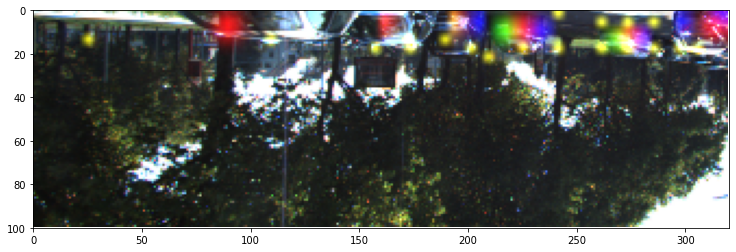

In [46]:
visualize_mask(img, mask)

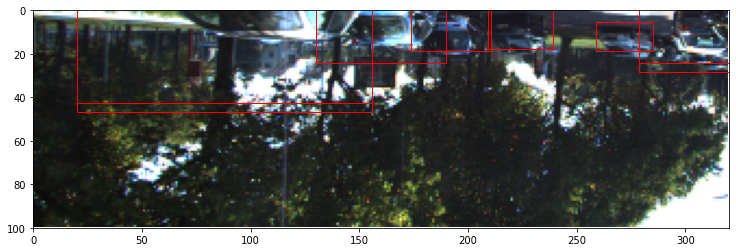

In [47]:
visualize_2D(img, mask, regr_size, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


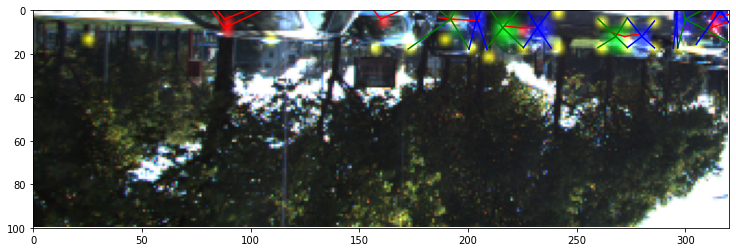

In [48]:
visualize_3D(img, mask, regr_3D, 4)